### Moran-Felsenszwalb tissue domain segmentation workflow

Note that a more computationally efficient implementation of the Moran-Felsenszwalb workflow is available. 

In [1]:
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
from sklearn.preprocessing import minmax_scale
from skimage.measure import label
from sklearn.cluster import KMeans
from scipy import stats
import time

from moran_imaging.fast_moran_felzenszwalb_segmentation import get_moran_felzenszwalb_segmentation

In [10]:
# Fix random seed
random.seed(0)

# Seaborn plotting style
sns.set(style="whitegrid", font_scale=1)

# Define colormaps
colormap_reverse = sns.blend_palette([".99", "darkblue"], as_cmap=True)
num_clusters = 15
num_viridis = int(np.floor(num_clusters/2))
num_coolwarm = int(num_clusters - num_viridis)
viridis = plt.cm.get_cmap('viridis_r', num_viridis) 
coolwarm = sns.color_palette('coolwarm', as_cmap=True)(np.linspace(0, 1, num_coolwarm))
combined_colors = np.vstack([viridis(np.linspace(0, 1, num_viridis)), coolwarm])
combined_cmap = ListedColormap(combined_colors)

C:\Users\Leo\AppData\Local\Temp\ipykernel_27276\1588914870.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis_r', num_viridis)


In [3]:
def make_ion_image(data, image_shape, background_mask, fill_zeros=True, show_image=True, colormap='viridis'):
    
    # Fill background pixels with zeros (default) or NaN
    pixel_grid = np.zeros((image_shape[0]*image_shape[1], ))
    pixel_grid[np.invert(background_mask)] = data
    
    if not fill_zeros:
        pixel_grid[background_mask] = np.nan
    
    # Reshape data
    ion_image = np.reshape(pixel_grid, image_shape)
    
    # Plot ion image 
    if show_image == True: 
        plt.figure(dpi=100)
        plt.imshow(ion_image, cmap=colormap)
        plt.axis('off')
        plt.show()
        
    return ion_image

In [4]:
def kmeans_superpixel_coloring(segments, cluster_labels, num_pixels, background_mask): 
    
    segmentation_labels = label(segments).flatten()[np.invert(background_mask)]
    mapping_pixel_to_segment = segmentation_labels
    all_segment_labels = np.unique(mapping_pixel_to_segment)
    dict_segment_to_pixels = {}
    for segment_label in all_segment_labels: 
        dict_segment_to_pixels[segment_label] = mapping_pixel_to_segment == segment_label

    segment_label_dict = {}
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        pixel_labels_segment = cluster_labels[mask_segment]
        cluster_segment_label = stats.mode(pixel_labels_segment)[0]
        segment_label_dict[segment_label] = cluster_segment_label

    final_cluster_labels = np.zeros(num_pixels)
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        final_cluster_labels[mask_segment] = segment_label_dict[segment_label]
        
    return final_cluster_labels

#### Load imaging mass spectrometry data

In [5]:
with open('./Zebra_fish_UMAP_dataset.pickle', 'rb') as handle:
    zebra_fish_dict = pickle.load(handle)

image_shape = zebra_fish_dict['image_shape'] 
background_mask = zebra_fish_dict['background_mask'] 
pixel_order = zebra_fish_dict['pixel_order']  
dataset_UMAP = zebra_fish_dict['dataset_UMAP'] 
acquisition_mask = np.invert(background_mask)
num_pixels = dataset_UMAP.shape[0]

#### Fast Moran-Felsenszwalb segmentation 

In [6]:
mask = np.reshape(acquisition_mask, image_shape).astype(bool)
dataset_UMAP = dataset_UMAP[:, [0, 1, 2, 4, 7]]
image = np.zeros((dataset_UMAP.shape[1], *image_shape))
image[:, mask] = dataset_UMAP.T

start_time = time.time()
segmentation = get_moran_felzenszwalb_segmentation(image, mask, num_clusters, felzenszwalb_scale=40, 
                                                   felzenszwalb_sigma=0.2, felzenszwalb_min_size=80)
end_time = time.time()
segmentation_time = end_time - start_time
print('Runtime:', segmentation_time)

C:\Users\Leo\Documents\Second_paper\Final_2nd_paper\Final_final\Comparisons\moran_imaging\fast_moran_felzenszwalb_segmentation.py:94: RuntimeWarning: Got image with third dimension of 5. This image will be interpreted as a multichannel 2d image, which may not be intended.
  felzenszwalb_segmentation = skimage.segmentation.felzenszwalb(


Runtime: 161.969566822052


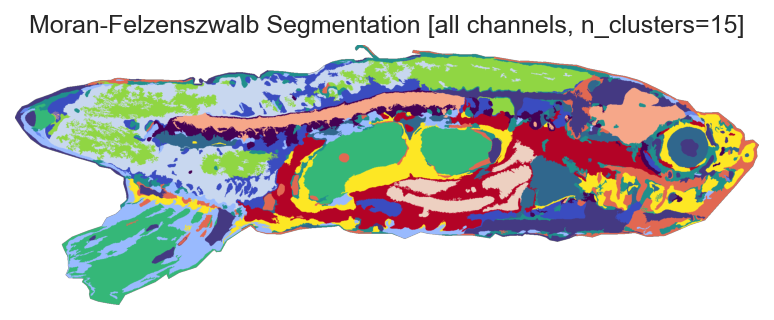

In [11]:
# Plot results
plt.figure(dpi=150)
segmentation = np.ma.array(segmentation, mask=~mask)
plt.imshow(segmentation, cmap=combined_cmap)
plt.title("Moran-Felzenszwalb Segmentation [all channels, n_clusters=15]")
plt.axis("off")
plt.show()